In [2]:
import os
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
from IPython import display 

%matplotlib inline

# Exploration

### Merge masks

To start, we will merge masks. This can be done by adding images matrices as they are without intersection and "binary"

In [31]:
for folder in glob.glob("images/train/*"):
    folder_name = os.path.basename(folder)
    for idx, mask_url in enumerate(glob.glob("images/train/" + folder_name + "/masks/*.png")):
        mask_img = Image.open(mask_url)
        mask_img = np.asarray(mask_img)
        if idx == 0:
            full_mask = mask_img
        else:
#             full_mask.paste(mask_img)
            full_mask = full_mask + mask_img
    full_mask = Image.fromarray(full_mask)
    full_mask.save("images/train/" + folder_name + "/masks/full_mask.png")

Now, every images, will have a mask called "full_mask.png". We can now display both images and masks

### find out what we are looking for

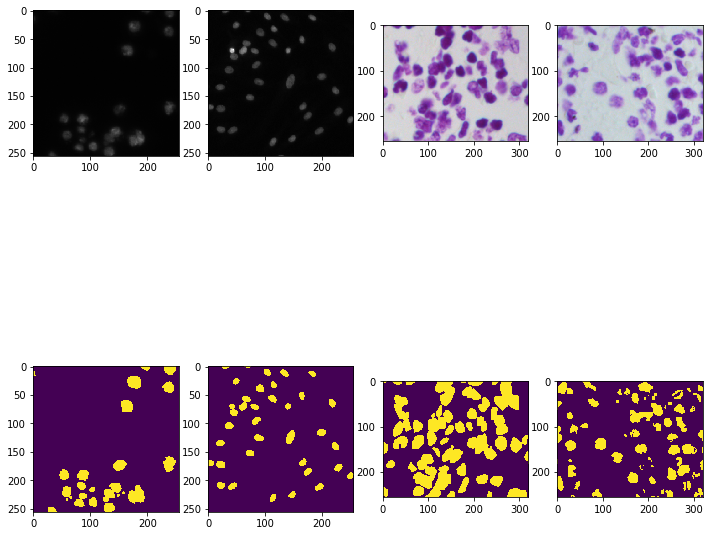

In [19]:
f, axarr = plt.subplots(2, 4, figsize=(12,12))
for idx, folder in enumerate(glob.glob("images/train/*")[:4]):
    folder_name = os.path.basename(folder)
    mask_url = "images/train/" + folder_name + "/masks/full_mask.png"
    image_url = glob.glob("images/train/" + folder_name + "/images/*.png")[0]  # sorry, it's ugly; I know :D
    mask_img = Image.open(mask_url)
    image_img = Image.open(image_url)
    axarr[0, idx].imshow(np.asarray(image_img))
    axarr[1, idx].imshow(np.asarray(mask_img))
plt.show()

Now, we know that we must discover all "cells" aiether pink or white (depending on the process used to get them)

### Check sizes

Prior any resizing, let's take a look at images sizes. We can see above that for all 3 images, we have the same height. Maybe wa can find a constant dimensions

In [10]:
# name, width, height = [], [], []
# for idx, img in enumerate(glob.glob("images/train/*/images/*.png")):
#     pil_im = Image.open(img)
#     name.append(os.path.basename(img))
#     width.append(pil_im.size[0])
#     height.append(pil_im.size[1])

# df = pd.DataFrame({"image": name, "width" : width, "height" : height})
# df.to_csv("dataset/dimensions_train.csv", index=False)

In [12]:
df=pd.read_csv("dataset/dimensions_train.csv")

In [17]:
df["height"].value_counts()
# df["height"].hist(bins=100)

256     446
520      92
360      91
1024     16
512      13
603       6
260       5
1040      1
Name: height, dtype: int64

In [18]:
df["width"].value_counts()

256     334
320     112
696      92
360      91
1024     16
640      13
1272      6
347       5
1388      1
Name: width, dtype: int64

<font style="font-weight:bold" color='red'>Attention</font>: Images are evaluated on IoU (see <a href="https://www.kaggle.com/c/data-science-bowl-2018#evaluation">link</a>). As a result, if we resize images, pixel index will change and don't match expected one from evaluation. A a result, we cannot do it. We will have to check for models taking all size of images.

### Augmentation on images

As we saw previously, we must detect "white" or "pink" dots. To help the model to learn, we can probably look how to play with contrast to ease the learning.

First, let's count how many color images we have and print some of them to see if there is only a white/pink format

In [28]:
bw = 0
c = 0
for idx, img in enumerate(glob.glob("images/train/*/images/*.png")[:5]):
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    cv2.imshow('image', gray)
    plt.plot()

In [25]:
c

0

In [ ]:
https://gist.github.com/meetshah1995/6a5ad112559ef1536d0191f8b9fe8d1e
    
https://arxiv.org/pdf/1505.04597.pdf
    
https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
    
    